## My best submission Private LB 0.902/Public LB 0.901 - would have been in the money/gold medal zone
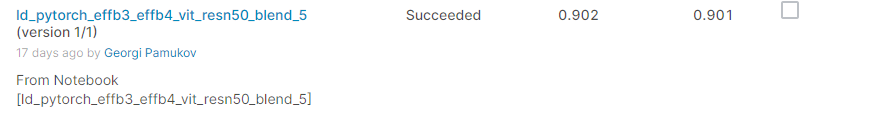

### General approach
* Final models were trained on the FULL data.
* Still used CV for validation/evaluation purposes only.

### Models
effnet b3/b4, vit, resnext50 architectures
Label Smoothing
Various loss functions: CE, Symmetric CE, Taylor CE
Various schedulers: Gradual Warmup/CosineAnnealingWarmRestarts
Augmentation: played mostly around crops/cutmix apart from the standard techniques.
Data:
only 2020
pretrain on 2019, train on 2020
train on both (one pass)

### Ensemble:
Hierarchical blend:
* Blended different epoch/best of kind models first
* Then blended the already blended “super” models
* Used CV to optimise the weights

You can find more details on my approach here: https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/220752

Inference code taken with modifications from this wonderful notebook (please upvote it): https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta

In [ ]:
package_path = '../input/pytorch-image-models/pytorch-image-models-master' #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
import sys; sys.path.append(package_path)

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss

In [ ]:
train = pd.read_csv('../input/cassava-leaf-disease-merged/merged.csv')
train.head()

In [ ]:
train.label.value_counts()

In [ ]:
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

# Helper Functions

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [ ]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

# Define Train\Validation Image Augmentations

In [ ]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [ ]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

# Model

In [ ]:
# ld-efficientnet-b4-best

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [0,1,2,3],
    'weights': [1,1,1,1]
}

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG['model_arch'], pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG['model_arch'], pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG['n_class'])

    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CustomEfficientNet(CFG['model_arch']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-efficientnet-b4-best/{}_fold{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
    
    del model
    torch.cuda.empty_cache()
    
tst_preds_0 = tst_preds

In [ ]:
# ld-efficientnet-b3-best

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'tf_efficientnet_b3_ns',
    'img_size': 512,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [0,1,2,3],
    'weights': [1,1,1,1]
}

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG['model_arch'], pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG['model_arch'], pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG['n_class'])

    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CustomEfficientNet(CFG['model_arch']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-efficientnet-b3-best/{}_fold{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
    
    del model
    torch.cuda.empty_cache()
    
    
tst_preds_1 = tst_preds

In [ ]:
# ld-pytrch-effnet-b3-lr-lbs-valprv

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'tf_efficientnet_b3_ns',
    'img_size': 512,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [5,6,8,9],
    'weights': [1,1,1,1]
}

class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CassvaImgClassifier(CFG['model_arch'], CFG['n_class']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-pytrch-effnet-b3-lr-lbs-valprv-train/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
    
    del model
    torch.cuda.empty_cache()
    
tst_preds_2 = tst_preds

In [ ]:
# ld-pytorch-tpu-vit-base-patch16-tcel-vldprv-train

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'vit_base_patch16_384',
    'img_size': 384,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [3,5,7,11],
    'weights': [1,1,1,1]
}

class CustomViT(nn.Module):
    def __init__(self, model_name=CFG['model_arch'], pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG['n_class'])

    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CustomViT(CFG['model_arch']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-pytorch-tpu-vit-base-patch16-tcel-vldprv-train/{}_fold{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
        
    del model
    torch.cuda.empty_cache()
    
tst_preds_3 = tst_preds

In [ ]:
# ld-pytorch-tpu-resnext50-tcel-1-vldprv-train

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'resnext50_32x4d',
    'img_size': 512,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [3,4,6,10],
    'weights': [1,1,1,1]
}

class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG['model_arch'], pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG['model_arch'], pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG['n_class'])

    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    # overwrite to point to prev data
    val_idx = train[train["source"]==2019].index
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CustomResNext(CFG['model_arch']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-pytorch-tpu-resnext50-tcel-vldprv-train/{}_fold{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
    
    del model
    torch.cuda.empty_cache()
    
tst_preds_4 = tst_preds

In [ ]:
# ld-pytorch-tpu-effnet-b4-gws-prtr-vldprv

CFG = {
    'fold_num': 6,
    'n_class':5,
    'seed': 42,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 32,
    'train_bs': 8,
    'valid_bs': 8,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1,
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [2,4,10,13],
    'weights': [1,1,1,1]
}

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG['model_arch'], pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG['model_arch'], pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG['n_class'])

    def forward(self, x):
        x = self.model(x)
        return x


seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
    # we'll train fold 0 first
    if fold > 0:
        break 

    print('Inference fold {} started'.format(fold))
    
    test = pd.DataFrame()
    test['image_id'] = list(os.listdir('../input/cassava-leaf-disease-classification/test_images/'))
    test_ds = CassavaDataset(test, '../input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(CFG['device'])
    model = CustomEfficientNet(CFG['model_arch']).to(device)
    
    tst_preds = []
    
    for i, epoch in enumerate(CFG['used_epochs']):    
        model.load_state_dict(torch.load('../input/ld-pytorch-tpu-effnet-b4-gws-prtr-vldprv/{}_fold{}_{}'.format(CFG['model_arch'], fold, epoch)))
        
        with torch.no_grad():
            for _ in range(CFG['tta']):
                tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

    tst_preds = np.mean(tst_preds, axis=0) 
    
    del model
    torch.cuda.empty_cache()
    
tst_preds_5 = tst_preds

In [ ]:
# blend - CV scores used to otimise the weights =============================================================
tst_preds = (tst_preds_0*0.7 + tst_preds_1*0.3)*0.25 + tst_preds_2*0.25 + tst_preds_3*0.25 + tst_preds_4*0.1 + tst_preds_5*0.15

In [ ]:
test['label'] = np.argmax(tst_preds, axis=1)
test.head()

In [ ]:
test.to_csv('submission.csv', index=False)